In [32]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [33]:
adult_icu = pd.read_csv("/home/pulkitmathur1800/csc2548_ml4h/adult_icu")
adult_icu = adult_icu.drop(['subject_id','hadm_id','icustay_id'],axis=1)
adult_icu.head()

,age,mort_icu,first_hosp_stay,first_icu_stay,adult_icu,eth_asian,eth_black,eth_hispanic,eth_other,eth_white,...,phosphate,platelet,potassium,ptt,inr,pt,sodium,bun,wbc,train
0,76.0,0,1,1,1,0,0,0,0,1,...,4.8,282.0,5.4,30.7,1.3,13.5,136.0,53.0,12.7,0
1,65.0,0,1,1,1,0,0,0,0,1,...,8.5,315.0,5.4,139.0,1.4,14.6,138.0,62.0,10.6,0
2,41.0,1,1,1,1,0,0,0,1,0,...,2.9,258.0,2.8,21.7,1.1,12.7,140.0,16.0,7.5,1
3,72.0,0,1,1,1,0,0,0,0,1,...,6.6,156.0,4.9,55.2,1.7,15.9,138.0,28.0,8.4,1
4,39.0,0,1,1,1,0,0,0,0,1,...,3.9,216.0,3.5,44.1,1.2,13.7,139.0,13.0,16.6,1


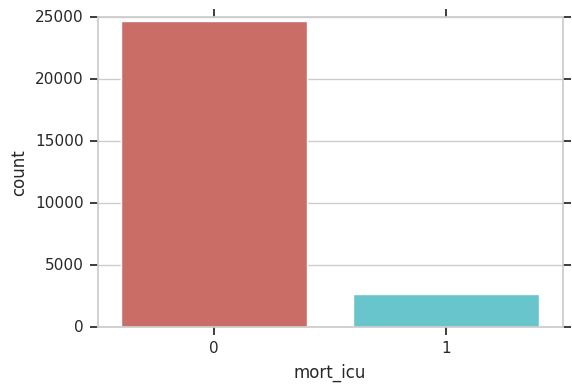

In [34]:
sns.countplot(x='mort_icu',data=adult_icu, palette='hls')
plt.show()

In [35]:
Y = adult_icu[['mort_icu','train']] 
Y_train,Y_test = Y.loc[Y['train']==1],Y.loc[Y['train']==0]
Y_train,Y_test = Y_train.drop(['train'],axis=1).values.squeeze(),Y_test.drop(['train'],axis=1).values.squeeze()

In [36]:
bool_cols = [col for col in adult_icu if np.isin(adult_icu[col].dropna().unique(),[0, 1]).all()]
non_bool_cols = [item for item in adult_icu.columns if item not in bool_cols]

X_train,X_test = adult_icu.loc[adult_icu['train']==1],adult_icu.loc[adult_icu['train']==0]
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train[non_bool_cols])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=non_bool_cols)
X_train_scaled = X_train_scaled.join(X_train[bool_cols])
X_test_scaled = scaler.fit_transform(X_test[non_bool_cols])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=non_bool_cols)
X_test_scaled = X_test_scaled.join(X_test[bool_cols])

X_train_scaled,X_test_scaled = X_train_scaled.drop(['train','mort_icu'],axis=1),X_test_scaled.drop(['train','mort_icu'],axis=1)

In [37]:
classifier = LogisticRegression(random_state=0,penalty="l2", C=3)
classifier.fit(X_train_scaled, Y_train)
Y_pred = classifier.predict(X_test_scaled)
matrix = confusion_matrix(Y_test, Y_pred)
Y_test_prob = classifier.predict_proba(X_test_scaled)
print("confusion matrix: ", matrix)
print("Accuracy: ",classifier.score(X_train_scaled, Y_train))
print("AUC: ",roc_auc_score(Y_test,Y_test_prob[:,1])*100)

confusion matrix:  [[7153  147]
 [ 682  126]]
Accuracy:  0.907068607069
AUC:  77.7503729825


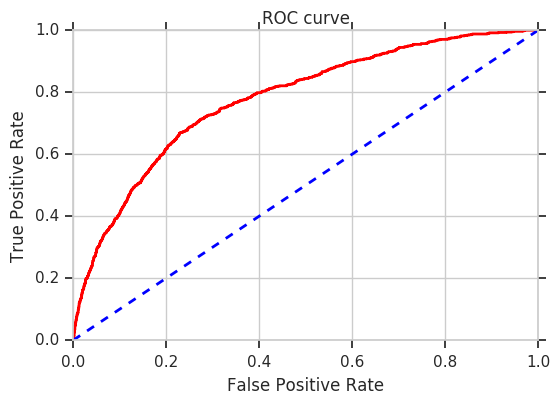

In [38]:
fpr, tpr,_=roc_curve(Y_test,Y_test_prob[:,1],pos_label=1)
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [39]:
coefs = classifier.coef_[0]
top_five = np.argpartition(coefs, -5)[-5:]
top_five = top_five[np.argsort(coefs[top_five])]
print(X_train[top_five].columns[:])

Index(['meanbp_mean', 'admType_NEWBORN', 'sysbp_min', 'glucose',
       'resprate_mean'],
      dtype='object')


In [40]:
least_five = np.argpartition(coefs, 15)[15:]
least_five = least_five[np.argsort(coefs[least_five])]
print(least_five)
X_train[least_five].columns

[53 20 31 38 50 23 46 49 40 24 55 45 39 48 13 52 11 42 14 56 54 36 51 27 35
 47  0  7 41  3  2  5 22 15 32 34 43 25 12 17 44 28]


Index(['inr', 'diasbp_min', 'tempc_mean', 'aniongap', 'platelet', 'meanbp_min',
       'hemoglobin', 'phosphate', 'bicarbonate', 'meanbp_max', 'sodium',
       'hematocrit', 'albumin', 'magnesium', 'admType_URGENT', 'ptt',
       'admType_EMERGENCY', 'creatinine', 'heartrate_min', 'bun', 'pt',
       'glucose_max', 'potassium', 'resprate_max', 'glucose_min', 'lactate',
       'age', 'eth_hispanic', 'bilirubin', 'first_icu_stay', 'first_hosp_stay',
       'eth_asian', 'diasbp_mean', 'heartrate_max', 'spo2_min', 'spo2_mean',
       'chloride', 'meanbp_mean', 'admType_NEWBORN', 'sysbp_min', 'glucose',
       'resprate_mean'],
      dtype='object')

In [41]:
adult_notes_raw = pd.read_csv("/home/pulkitmathur1800/csc2548_ml4h/adult_notes")
adult_notes_raw = adult_notes_raw.drop(['subject_id','hadm_id','icustay_id'],axis=1)
print(adult_notes_raw.shape)
adult_notes_raw.head()

(27348, 3)


,chartext,train,mort_icu
0,[**2101-10-21**] 1:00 AM\n CHEST (PORTABLE AP)...,0,0
1,[**2175-5-31**] 11:03 AM\n RENAL TRANSPLANT U....,0,0
2,[**2149-11-10**] 11:07 AM\n CT HEAD W/O CONTRA...,1,1
3,ADMIT NOTE\nPLEASE SEE ADMISSION HISTORY/FHP.\...,1,0
4,[**2167-1-9**] 6:11 AM\n CHEST (PORTABLE AP) ...,1,0


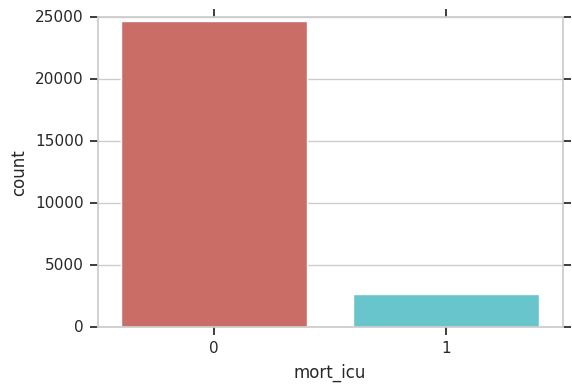

In [42]:
sns.countplot(x='mort_icu',data=adult_notes_raw, palette='hls')
plt.show()

In [43]:
#deleting punctuation
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
adult_notes_raw['chartext'].dropna(inplace=True)
adult_notes_raw.chartext = adult_notes_raw.chartext.apply(lambda x: tokenizer.tokenize(x))
adult_notes_raw.head()

,chartext,train,mort_icu
0,"[2101, 10, 21, 1, 00, AM, CHEST, PORTABLE, AP,...",0,0
1,"[2175, 5, 31, 11, 03, AM, RENAL, TRANSPLANT, U...",0,0
2,"[2149, 11, 10, 11, 07, AM, CT, HEAD, W, O, CON...",1,1
3,"[ADMIT, NOTE, PLEASE, SEE, ADMISSION, HISTORY,...",1,0
4,"[2167, 1, 9, 6, 11, AM, CHEST, PORTABLE, AP, C...",1,0


In [44]:
#deleting stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
adult_notes_raw['chartext'].dropna(inplace=True)
adult_notes_raw.chartext = adult_notes_raw.chartext.apply(lambda x: [item for item in x if item not in stop_words])

In [45]:
#handling null values if any
adult_notes_raw['chartext'].fillna("empty", inplace=True)
adult_notes_raw.chartext = adult_notes_raw.chartext.apply(lambda x: ' '.join(map(str, x)))
print(adult_notes_raw.chartext.isnull().sum())

0


In [46]:
#train-test-split
X2 = adult_notes_raw.drop(['mort_icu'],axis=1)
X_train_notes,X_test_notes = X2.loc[X2['train']==1].drop(['train'],axis=1),X2.loc[X2['train']==0].drop(['train'],axis=1)
Y2 = adult_notes_raw[['mort_icu','train']] 
Y_train_notes,Y_test_notes = Y2.loc[Y2['train']==1],Y2.loc[Y2['train']==0]
Y_train_notes,Y_test_notes = Y_train_notes.drop(['train'],axis=1).values.squeeze(),Y_test_notes.drop(['train'],axis=1).values.squeeze()

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
X_train_notes = v.fit_transform(np.array(X_train_notes['chartext']))
X_test_notes = v.transform(np.array(X_test_notes['chartext']))

In [48]:
notes_classifier = LogisticRegression(random_state=0,penalty="l1", C=2)
notes_classifier.fit(X_train_notes, Y_train_notes)
Y_pred_notes = notes_classifier.predict(X_test_notes)
matrix = confusion_matrix(Y_test_notes, Y_pred_notes)
Y_test_notes_prob = notes_classifier.predict_proba(X_test_notes)
print(matrix)
print("Accuracy: ",notes_classifier.score(X_train_notes, Y_train_notes))
print("AUC: ",roc_auc_score(Y_test_notes,Y_test_notes_prob[:,1])*100)

[[7225   75]
 [ 660  148]]
Accuracy:  0.91761954262
AUC:  83.984733148


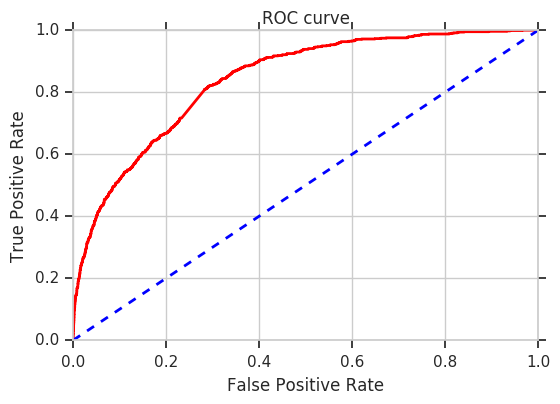

In [49]:
fpr, tpr,_=roc_curve(Y_test_notes,Y_test_notes_prob[:,1])
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [50]:
v.get_feature_names()[87736]

'deatails'

In [51]:
coefs = notes_classifier.coef_[0]
top_five = np.argpartition(coefs, -10)[-10:]
top_five = top_five[np.argsort(coefs[top_five])]
print(top_five)
for a in top_five:
    print(v.get_feature_names()[a])

[ 98634  82821 121776 124438  81962  87737 134053  92027  85169 140117]
extensive
comfort
meeting
mottled
cmo
death
paucity
dnr
corneal
prognosis
